# Data Visualization Project -- Investigation of the most influential factors for Opioid Crisis


# Scott Lai

 The prescription opioids use is popular be using in some specific area, such as cancer therapy, and pain relief. From 1999 to 2016, more than 630000 people have died from a drug overdose. As of 2016, 2.1 million Americans have an opioid use disorder, and more than 63600 people died from drug overdoses, which makes it the leading cause of injury-related death in the United States (CDC, 2018). I want to use the statistics to dig into the related data and come up with the idea to help end this crisis. Since the different states have different limitation and policy for the opioid use, I try to connect the opioid cause death rate data with all the county in the United States. From that, I can use multiple algorithms to dealing the data, including data visualization to show the distribution for the affection.

## Methodology (Algorithm or analysis)
After gathering raw data, I first process the data that emerge different columns into one general data set, including the number of different races of people, different genders, income levels etc. in different counties. After sorting the data by different counties, I try to find out how different factors are related to the death number within Opioid death rate in different counties in each year. I will conduct a one-way ANOVA analysis in order to find out how different the races relating with the death numbers due to Opioid Crisis. As reports,  from 2013 to 2016 is the most increasing year for the Opioid crisis, I'm interesting to find out the relations between each of them and the yearly change for the opioid crisis. The result be presented by showing a map of America, categorized by different county. Furthermore, I will use different colors to represent how close different factors are related to the death rate with linear regression plots. After showing the connecting of different factors to the death rates, I sum up the report by concluding the most influential factor to Opioid Crisis and which year was most effected by opioid using. By obtaining such conclusion, people will be more aware of such factor, hence will help prevent Opioid Crisis or reduce it in general.

## Set Up

### Downloading Packages

In [149]:
import pandas as pd
import geopandas                            
from shapely.geometry import Point         
import matplotlib.pyplot as plt  
import patsy                           
import statsmodels.api as sm           
import statsmodels.formula.api as smf  
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np
%matplotlib inline

###  Dataset Import and Retrieving 

As one of the county level project, this study contains seven dataset, which might hard to follow by each varible. Luckly, only one or two variables in each dataset will be using in this study. 

The following cell is using the cleaning process including split counties & States name into two dataset, create new varible, and drop unuse variables. 

### overview

In [224]:
from tabulate import tabulate 
print(tabulate([['The Opioid Cause of Death','4970','12','Death cause be due to use of opioids'],
                ['The Cancer Cause of Death', '2082', '9','Death cause by cancer'],
               ['Unemployment','12876','9','Unemployment rate, population, unemployed, etc'],
               ['Income and Poverty','12569','5','Income and Poverty Percent statistics '],
               ['Prescribing Rates','3143','4','Average of prescribing rate in U.S. counties'],
               ['Cartographic Boundary Shapefiles - States','56','10','cartographic boundary for USA states'],
               ['Cartographic Boundary Shapefiles - Counties','3233','10','cartographic boundary for USA counties']],
               headers = ['Dataset','Columns','Rows','description'],
               tablefmt = 'orgtbl'))

| Dataset                                     |   Columns |   Rows | description                                    |
|---------------------------------------------+-----------+--------+------------------------------------------------|
| The Opioid Cause of Death                   |      4970 |     12 | Death cause be due to use of opioids           |
| The Cancer Cause of Death                   |      2082 |      9 | Death cause by cancer                          |
| Unemployment                                |     12876 |      9 | Unemployment rate, population, unemployed, etc |
| Income and Poverty                          |     12569 |      5 | Income and Poverty Percent statistics          |
| Prescribing Rates                           |      3143 |      4 | Average of prescribing rate in U.S. counties   |
| Cartographic Boundary Shapefiles - States   |        56 |     10 | cartographic boundary for USA states           |
| Cartographic Boundary Shapefiles - Counties |      323

In [170]:
# Opioid death 
data_l = pd.read_csv("/home/scottlai/Documents/jupyter/Econ 690/project/dataChallenge/row data/multiple cause of death 2013-2016/Multiple Cause of Death, 1999-2016 .csv",thousands=',')
data_l = data_l.drop(columns = ["Crude Rate","Year Code",])
data_l['OpioidDeathRate'] = (data_l['Deaths'] / data_l['Population'])*1000
data_l.insert(1,'State',data_l['County'])
data_l['County'] = data_l["County"].map(lambda x: str(x)[:-4])
data_l['State'] = data_l['State'].map(lambda x: str(x)[-2:])

# Unempolyment 
unemp = pd.read_excel("/home/scottlai/Documents/jupyter/Econ 690/project/dataChallenge/laucnty13-16.xlsx",thousands=',')
unemp = unemp.drop(columns = ["Unnamed: 5","LAUS Code"])
unemp.rename(columns={'County Name/State Abbreviation':'County'}, inplace=True)
unemp['State FIPS Code'] = unemp['State FIPS Code'].apply(lambda x: '{0:0>2}'.format(x))
unemp['County FIPS Code'] = unemp['County FIPS Code'].apply(lambda x: '{0:0>3}'.format(x))
unemp.rename(columns={'State FIPS Code':'STATEFP','County FIPS Code':'COUNTYFP',
                      'Unemployment Rate (%)': 'UnemploymentRate'}, inplace=True)
unemp.insert(1,'State',unemp['County'])
unemp['County'] = unemp["County"].map(lambda x: str(x)[:-4])
unemp['State'] = unemp['State'].map(lambda x:str(x)[-2:])


#cancer death 
cancer = pd.read_csv("/home/scottlai/Documents/jupyter/Econ 690/project/dataChallenge/row data/cancer/cancer.csv",thousands=',')
cancer.insert(1,'State',cancer['County'])
cancer['County'] = cancer["County"].map(lambda x: str(x)[:-4])
cancer['State'] = cancer['State'].map(lambda x:str(x)[-2:])
cancer['County Code'] = cancer["County Code"].map(lambda x: str(x)[1:])
cancer['CancerDeathRate'] = (cancer['Deaths'] / cancer['Population'])*1000
cancer.drop(columns = ['UCD - ICD Chapter Code' , 
                       'UCD - ICD Chapter','Year Code'],inplace = True)


#the U.S. County Prescribing Rates
prescribing2013 = pd.read_excel('/home/scottlai/Documents/jupyter/Econ 690/project/dataChallenge/row data/U.S. County Prescribing Rates/U.S. County Prescribing Rates, 2013.xlsx',thousands=',')
prescribing2014 = pd.read_excel('/home/scottlai/Documents/jupyter/Econ 690/project/dataChallenge/row data/U.S. County Prescribing Rates/U.S. County Prescribing Rates, 2014.xlsx',thousands=',')
prescribing2015 = pd.read_excel('/home/scottlai/Documents/jupyter/Econ 690/project/dataChallenge/row data/U.S. County Prescribing Rates/U.S. County Prescribing Rates, 2015.xlsx',thousands=',')
prescribing2016 = pd.read_excel('/home/scottlai/Documents/jupyter/Econ 690/project/dataChallenge/row data/U.S. County Prescribing Rates/U.S. County Prescribing Rates, 2016.xlsx',thousands=',')
prescribing2016['2016 Prescribing Rate'].replace('–', np.nan,inplace = True)
prescribing2015['2015 Prescribing Rate'].replace('–', np.nan,inplace = True)
prescribing2014['2014 Prescribing Rate'].replace('–', np.nan,inplace = True)
prescribing2013['2013 Prescribing Rate'].replace('–', np.nan,inplace = True)
df = [prescribing2013,prescribing2014,prescribing2015,prescribing2016]
prescribing = reduce(lambda  left,right: pd.merge(left,right,on=['County','State','FIPS County Code'],
                                            how='outer'), df)
df1 = ['prescribing2013','prescribing2014','prescribing2015','prescribing2016']
prescribing['prescribingRateAVE'] = prescribing.iloc[:,3:].mean(axis = 1)
prescribing['County'] = prescribing["County"].map(lambda x: str(x)[:-4])


#Income and Poverty data
income = pd.read_csv('/home/scottlai/Documents/jupyter/Econ 690/project/dataChallenge/row data/income/Income and Poverty.csv',thousands= ',')
income = income[['Year','State','State / County Name','All Ages in Poverty Percent','Median Household Income in Dollars']]
income.rename(columns = {'State':'STATEFP'},inplace = True)
income.insert(1,'State',income['State / County Name'])
income["State / County Name"] = income["State / County Name"].map(lambda x: str(x)[:-4])
income['State'] = income['State'].map(lambda x: str(x)[-3:-1])
income.drop(columns = ['STATEFP'],inplace = True)
income.rename(columns = {'State / County Name': 'County', 'All Ages in Poverty Percent':'ProvertyPre',
                         'Median Household Income in Dollars':'HouseholdIncome'},inplace = True)


#geograph state / county code
states = geopandas.read_file('/home/scottlai/Documents/jupyter/Econ 690/project/dataChallenge/row data/map/cb_2017_us_state_5m/cb_2017_us_state_5m.shp')
states = states.loc[states['STUSPS'] != 'AK']
states = states.loc[states['STUSPS'] != 'HI']
states = states.loc[states['STUSPS'] != 'PR']
states = states.loc[states['STUSPS'] != 'MP']
states = states.loc[states['STUSPS'] != 'VI']
states = states.loc[states['STUSPS'] != 'GU']
states = states.loc[states['STUSPS'] != 'UM']
states = states.loc[states['STUSPS'] != 'AS']
counties = geopandas.read_file('/home/scottlai/Documents/jupyter/Econ 690/project/dataChallenge/row data/map/cb_2017_us_county_5m/cb_2017_us_county_5m.shp')
counties.rename(columns = {'NAME':'County'},inplace = True)
counties = pd.merge(left = counties, right = states[['STATEFP','STUSPS']], on = ['STATEFP'],how = 'inner')
counties.rename(columns = {'STUSPS':"State"},inplace = True)
counties = counties.loc[counties['STATEFP'] != '02']
counties = counties.loc[counties['STATEFP'] != '15']
counties = counties.loc[counties['STATEFP'] != '72']
counties = counties.loc[counties['STATEFP'] != '69']
counties = counties.loc[counties['STATEFP'] != '78']
counties = counties.loc[counties['STATEFP'] != '66']
counties = counties.loc[counties['STATEFP'] != '74']
counties = counties.loc[counties['STATEFP'] != '60']


**That is a lot of data**

Luckly we only pick only few piece from each of them.

Here are some of the **variables** retrieved:

* ***OpioidDeathRate*** :  Death rate cause by the opioid. OpioidDeathRate = Opioid Deaths Population / Total Population
* ***UnemploymentRate*** :    The unemployment Rate in each counties in United States. 
* ***CancerDeathRate*** :    The death rate related with cancer. 
* ***prescribingRateAVE*** :    The Average amount of opioids prescribed in the US from 2013 to 2016
* ***ProvertyPre*** :     All Ages of people in Poverty Percent base on median family income by family size from 2013 to 2016
* ***geometry*** :    The geometry information conduct for each counties in U.S. 


### Merge all the factors base on year from 2013 to 2016

Bese on some other research, 2017 is the **worst** year ever for drug overdose deaths in Americathe, and the high increasing time for Opioid Crisis is from **2013 to 2016**. Therefore, in here we choice all the dataset and varible from 2013 to 2016.

In order to show the different between each factor, this study **seperate** dataset *base on years*. which each year contains **County names, Opioid Death Rate for each year, State names,	Prescribing Rate in each year,  Cancer Death Rate in each year, and	Proverty percent in each counties for each year**. 



In [173]:
#Merge all 2013 data 
x13 = data_l.loc[data_l['Year'] == 2013][['County','OpioidDeathRate','State']]
y13 = prescribing[['County','2013 Prescribing Rate', 'State']]
z13 = cancer.loc[cancer['Year'] == 2013][['County','CancerDeathRate','State']]
k13 = income.loc[income['Year'] == 2013][['County','ProvertyPre','State']]
dataset13 = [x13,y13,z13,k13]

data_2013 = reduce(lambda  left,right: pd.merge(left,right,on=['County','State'],how = 'outer'), dataset13)
data_2013.rename(columns = {'OpioidDeathRate': 'OpioidDeathRate2013', 'CancerDeathRate':'CancerDeathRate2013', 
                            "2013 Prescribing Rate":'PrescribingRate2013'},inplace = True)
data_2013['County'] = data_2013["County"].map(lambda x:x.split()[0])
#data_2013.dropna(subset = ["OpioidDeathRate2013",'PrescribingRate2013','CancerDeathRate2013', 'ProvertyPre'])
#data_2013.fillna(0, inplace = True)
#data_2013 = data_2013.interpolate()

#Merge all 2014 data 
x14 = data_l.loc[data_l['Year'] == 2014][['County','State','OpioidDeathRate']]
y14 = prescribing[['County','2014 Prescribing Rate', 'State']]
z14 = cancer.loc[cancer['Year'] == 2014][['County','CancerDeathRate','State']]
k14 = income.loc[income['Year'] == 2014][['County','ProvertyPre','State']]
dataset14 = [x14,y14,z14,k14]

data_2014 = reduce(lambda  left,right: pd.merge(left,right,on=['County','State'],how = 'outer'), dataset14)
data_2014.rename(columns = {'OpioidDeathRate': 'OpioidDeathRate2014', 'CancerDeathRate':'CancerDeathRate2014', 
                            "2014 Prescribing Rate":'PrescribingRate2014'},inplace = True)
data_2014['County'] = data_2014["County"].map(lambda x:x.split()[0])
data_2014.dropna()
#data_2014.fillna(0, inplace = True)
#data_2014 = data_2014.interpolate()

#Merge all 2015 data 
x15 = data_l.loc[data_l['Year'] == 2015][['County','State','OpioidDeathRate']]
y15 = prescribing[['County','2015 Prescribing Rate', 'State']]
z15 = cancer.loc[cancer['Year'] == 2015][['County','CancerDeathRate','State']]
k15 = income.loc[income['Year'] == 2015][['County','ProvertyPre','State']]
dataset15 = [x15,y15,z15,k15]

data_2015 = reduce(lambda  left,right: pd.merge(left,right,on=['County','State'],how = 'outer'), dataset15)
data_2015.rename(columns = {'OpioidDeathRate': 'OpioidDeathRate2015', 'CancerDeathRate':'CancerDeathRate2015', 
                            "2015 Prescribing Rate":'PrescribingRate2015'},inplace = True)
data_2015['County'] = data_2015["County"].map(lambda x:x.split()[0])
#data_2015.fillna(0, inplace = True)
#data_2015 = data_2015.interpolate()

#Merge all 2015 data 
x16 = data_l.loc[data_l['Year'] == 2016][['County','State','OpioidDeathRate']]
y16 = prescribing[['County','2016 Prescribing Rate', 'State']]
z16 = cancer.loc[cancer['Year'] == 2016][['County','CancerDeathRate','State']]
k16 = income.loc[income['Year'] == 2016][['County','ProvertyPre','State']]
dataset16 = [x16,y16,z16,k16]

data_2016 = reduce(lambda  left,right: pd.merge(left,right,on=['County','State'],how = 'outer'), dataset16)
data_2016.rename(columns = {'OpioidDeathRate': 'OpioidDeathRate2016', 'CancerDeathRate':'CancerDeathRate2016', 
                            "2016 Prescribing Rate":'PrescribingRate2016'},inplace = True)
data_2016['County'] = data_2016["County"].map(lambda x:x.split()[0])


In order to maping the exactly factor feature, I choice to keep the missing value at this point, and will drop the NaN latter when doing regression. 

# Create Plots.

### GeoDataframe
Merge the geometry information with dataset for each year to mapping the visualazation plot on the map. 

Here we use 2013 GeoDataframe as an example

In [217]:
#opioid cause of death with geo
geo2013 = pd.merge(left=data_2013, right=counties[['County','State','geometry']], 
               on = ['County','State'], how='right')
geo2013 = geopandas.GeoDataFrame(geo2013, geometry='geometry')

geo2014 = pd.merge(left=data_2014, right=counties[['County','State','geometry']], 
               on = ['County','State'], how='right')
geo2014 = geopandas.GeoDataFrame(geo2014, geometry='geometry')

geo2015 = pd.merge(left=data_2015, right=counties[['County','State','geometry']], 
               on = ['County','State'], how='right')
geo2015 = geopandas.GeoDataFrame(geo2015, geometry='geometry')

geo2016 = pd.merge(left=data_2016, right=counties[['County','State','geometry']], 
               on = ['County','State'], how='right')
geo2016 = geopandas.GeoDataFrame(geo2016, geometry='geometry')

geo2013.head()

County  OpioidDeathRate2013 State  PrescribingRate2013  \
0  Alachua             0.098128    FL            41.295902   
1  Alachua             0.386399    FL            77.000000   
2  Alachua             0.386399    FL            76.200000   
3      Bay             0.141877    FL            41.491803   
4      Bay             0.193469    FL            41.687705   

   CancerDeathRate2013  ProvertyPre  \
0             0.064920          NaN   
1             0.051799          NaN   
2             0.065445         25.7   
3             0.063650          NaN   
4             0.062380          NaN   

                                            geometry  
0  POLYGON ((-82.658554 29.830144, -82.651494 29....  
1  POLYGON ((-82.658554 29.830144, -82.651494 29....  
2  POLYGON ((-82.658554 29.830144, -82.651494 29....  
3  POLYGON ((-85.99471199999999 30.311702, -85.99...  
4  POLYGON ((-85.99471199999999 30.311702, -85.99...

In [175]:
geo2013.isnull().sum()

County                    0
OpioidDeathRate2013    6054
State                     0
PrescribingRate2013    4697
CancerDeathRate2013    6641
ProvertyPre            4353
geometry                  0
dtype: int64

The table above show the missing value for each factors in the table. the merge causes a lot of missing value since some counties did not report any factors information, which shows as NaN, I did not drop or replace the missing value since it will cause the visible issue when the plot, which hard to find the distribution on the map. ( If I replace NaN by 0, the whole missing value would be plot as some light color close to what I want to see since the rate is mostly at a low level close to 0, the 0 joins would make it hard to distinguish.) So I'd rather keep the missing value as empty space.


### Plot the geometry distribution
the plots below are the distribution map in county level for four variables from 2013 to 2016

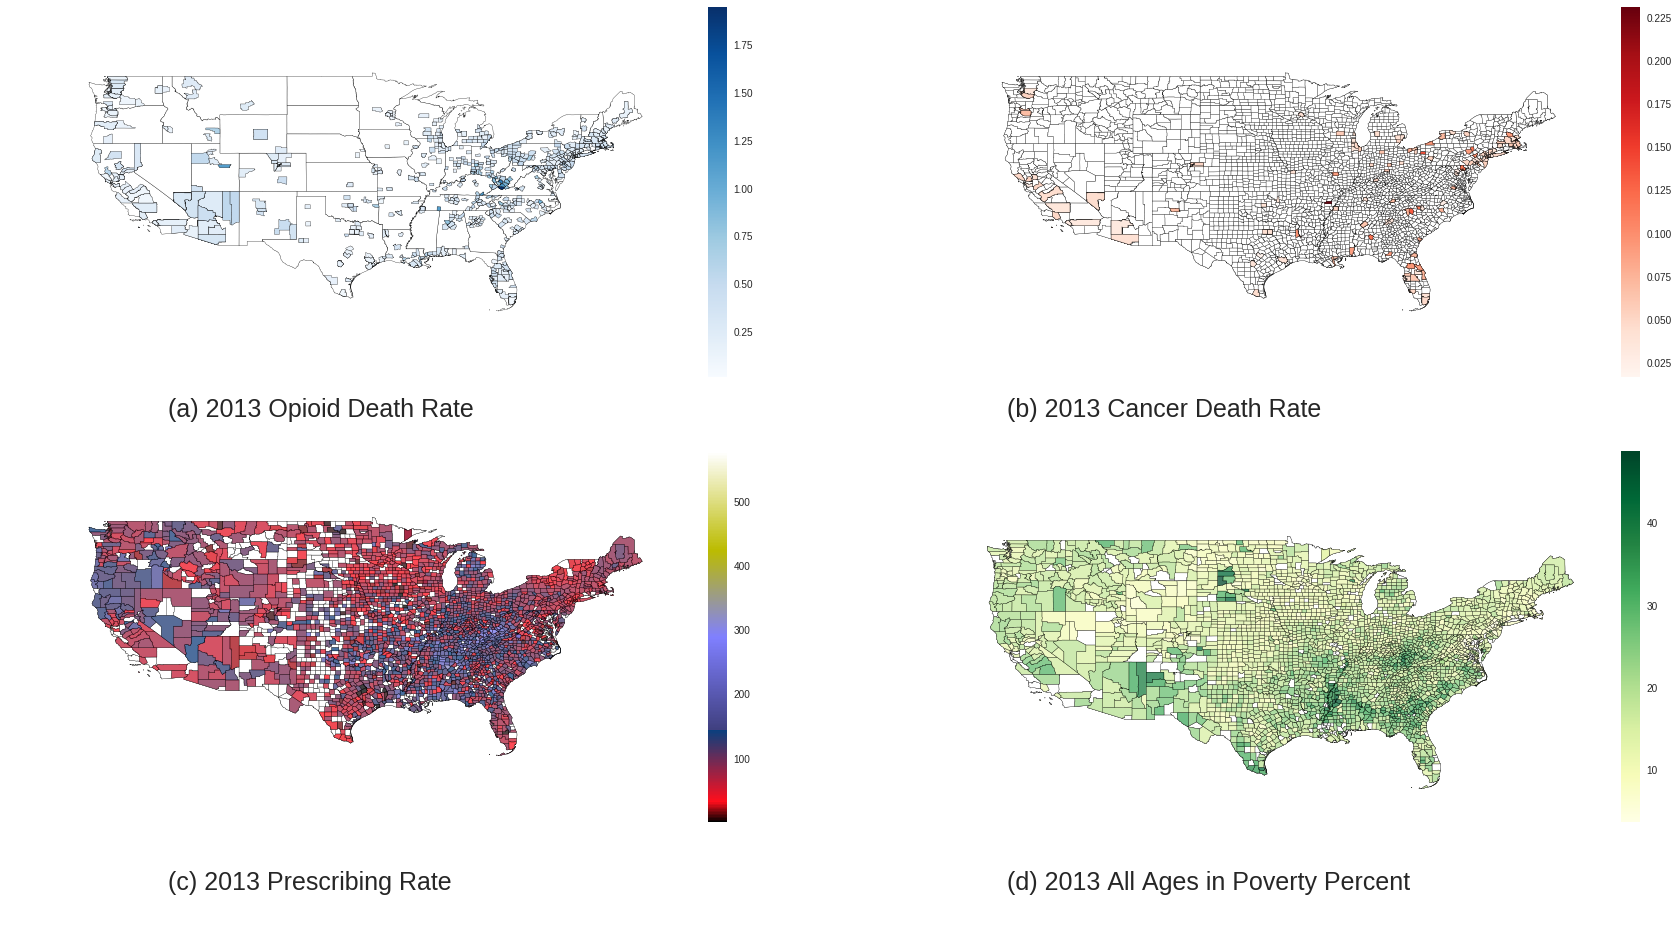

In [176]:
#Figure[1], Year 2013
# (a) Opioid Death Rate
fig, gax = plt.subplots(2,2,figsize=(30,15))
plt.xlim([-126,-66])
plt.ylim([24,55])
states.plot(edgecolor='black',color= 'white' ,ax=gax[0,0])
#counties.plot(edgecolor='black', color = 'white',ax=gax[0,0])
geo2013.dropna(subset=['OpioidDeathRate2013']).plot(edgecolor='black', 
                                                    column='OpioidDeathRate2013',  legend=True, 
                                                    cmap='Blues',ax=gax[0,0])
gax[0,0].annotate('(a) 2013 Opioid Death Rate',xy=(0.1, 0.55),  xycoords='figure fraction',size = 25)
gax[0,0].axis('off')


#(b) Cancer Death Rate
states.plot(edgecolor='black',color= 'white', ax=gax[0,1])
counties.plot( edgecolor='black', color = 'white',ax=gax[0,1])
geo2013.dropna(subset=['CancerDeathRate2013']).plot( edgecolor='black', 
                                                    column='CancerDeathRate2013',  legend=True,
                                                    cmap='Reds',ax=gax[0,1])
gax[0,1].annotate('(b) 2013 Cancer Death Rate',xy=(0.6, 0.55),  xycoords='figure fraction', size = 25)
gax[0,1].axis('off')


#(c) Prescribing Rate
states.plot( edgecolor='black',color= 'white',ax=gax[1,0] )
counties.plot( edgecolor='black', color = 'white',ax=gax[1,0])
geo2013.dropna(subset=['PrescribingRate2013']).plot( edgecolor='black', 
                                                    column='PrescribingRate2013',  legend=True, 
                                                    cmap='gist_stern',alpha = 0.75,ax=gax[1,0])
gax[1,0].annotate('(c) 2013 Prescribing Rate',xy=(0.1, 0.04),  xycoords='figure fraction', size = 25)
gax[1,0].axis('off')


#(d) All Ages in Poverty Percent
states.plot( edgecolor='black',color= 'white' ,ax=gax[1,1])
counties.plot( edgecolor='black', color = 'white',ax=gax[1,1])
geo2013.dropna(subset=['ProvertyPre']).plot( edgecolor='black', 
                                            column='ProvertyPre',  legend=True, 
                                            cmap='YlGn',alpha = 0.75,ax=gax[1,1])
gax[1,1].annotate('(d) 2013 All Ages in Poverty Percent',xy=(0.6, 0.04),  xycoords='figure fraction', size = 25)
gax[1,1].axis('off')
plt
plt.show()

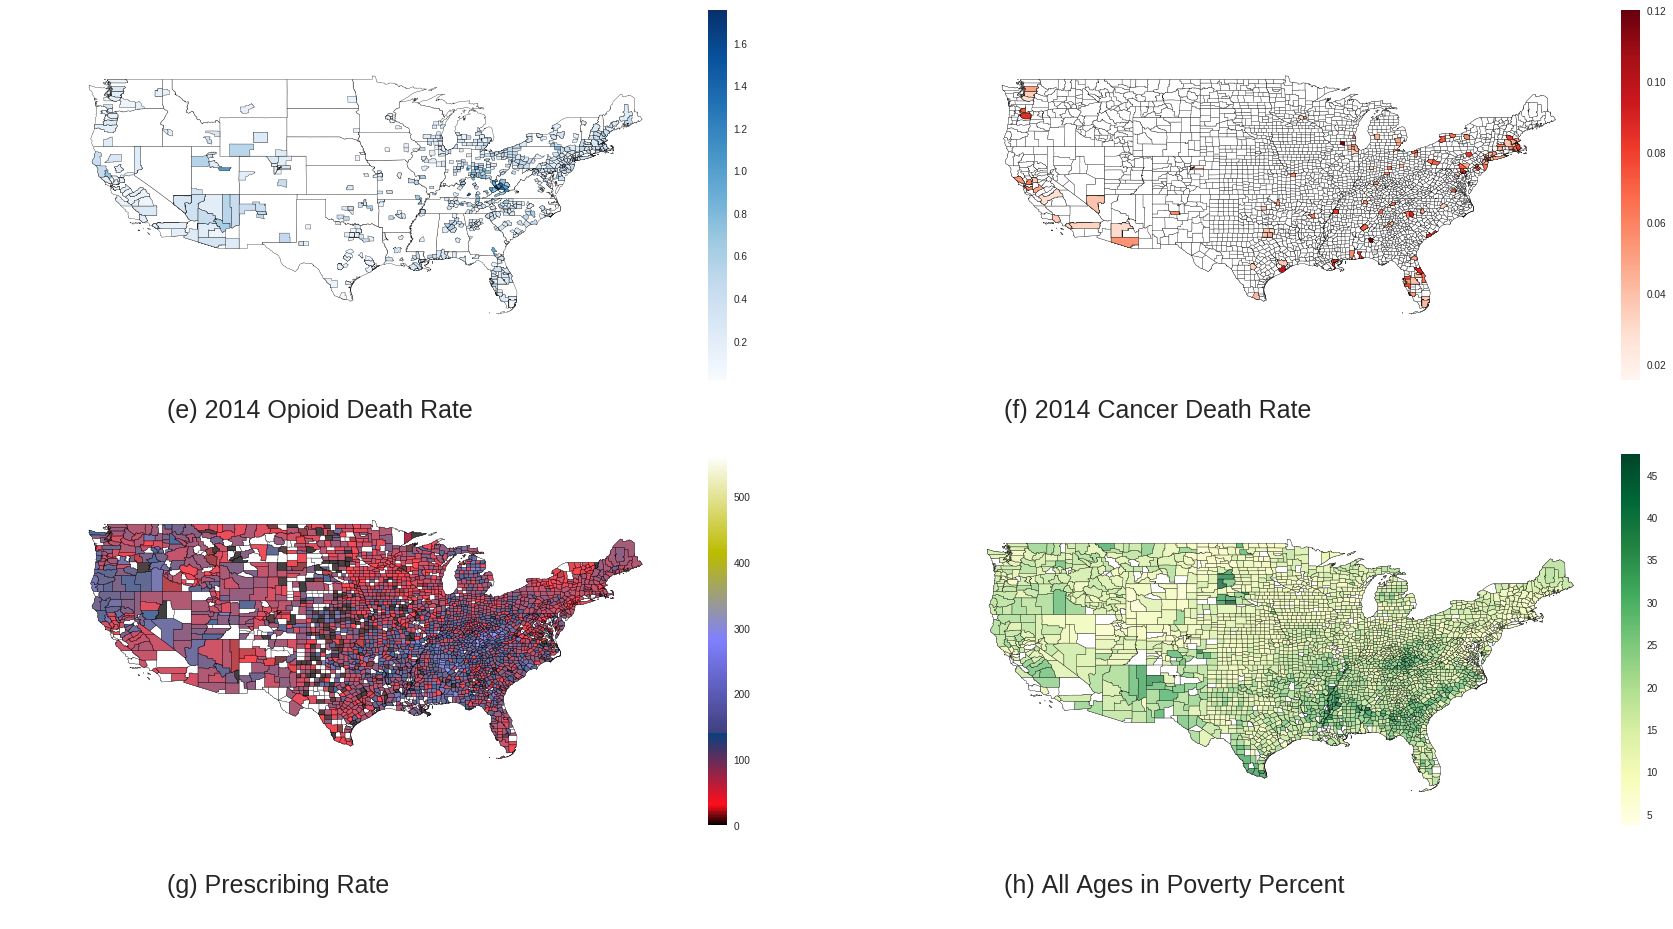

In [177]:
#Figure[1], Year 2014
#(a) Opioid Death Rate
fig, gax = plt.subplots(2,2 , figsize=(30,15))
plt.xlim([-126,-66])
plt.ylim([24,55])
states.plot(ax = gax[0,0], edgecolor='black',color= 'white' )
#counties.plot(ax=gax[0,0], edgecolor='black', color = 'white')
geo2014.dropna(subset=['OpioidDeathRate2014']).plot(ax=gax[0,0], edgecolor='black', 
                                                    column='OpioidDeathRate2014',  legend=True, cmap='Blues')
gax[0,0].annotate('(e) 2014 Opioid Death Rate',xy=(0.1, 0.55),  xycoords='figure fraction',size = 25)
#gax.set_title('Figure[2], U.S County Opioid Death Rate, 2014', size = 30)
gax[0,0].axis('off')


#(f) Cancer Death Rate
states.plot(ax = gax[0,1], edgecolor='black',color= 'white' )
counties.plot(ax=gax[0,1], edgecolor='black', color = 'white')
geo2014.dropna(subset=['CancerDeathRate2014']).plot(ax=gax[0,1], edgecolor='black', 
                                                    column='CancerDeathRate2014',  legend=True, cmap='Reds')
gax[0,1].annotate('(f) 2014 Cancer Death Rate',xy=(0.6, 0.55),  xycoords='figure fraction', size = 25)
gax[0,1].axis('off')


#(c) Prescribing Rate
states.plot(ax = gax[1,0], edgecolor='black',color= 'white' )
counties.plot(ax=gax[1,0], edgecolor='black', color = 'white')
geo2014.dropna(subset=['PrescribingRate2014']).plot(ax=gax[1,0], edgecolor='black', 
                                                    column='PrescribingRate2014',  legend=True, 
                                                    cmap='gist_stern',alpha = 0.75)
gax[1,0].annotate('(g) Prescribing Rate',xy=(0.1, 0.04),  xycoords='figure fraction', size = 25)
gax[1,0].axis('off')


#(d) All Ages in Poverty Percent
states.plot(ax = gax[1,1], edgecolor='black',color= 'white' )
counties.plot(ax=gax[1,1], edgecolor='black', color = 'white')
geo2014.dropna(subset=['ProvertyPre']).plot(ax=gax[1,1], edgecolor='black', 
                                            column='ProvertyPre',  legend=True, cmap='YlGn',alpha = 0.75)
gax[1,1].annotate('(h) All Ages in Poverty Percent',xy=(0.6, 0.04),  xycoords='figure fraction', size = 25)
gax[1,1].axis('off')
plt.show()

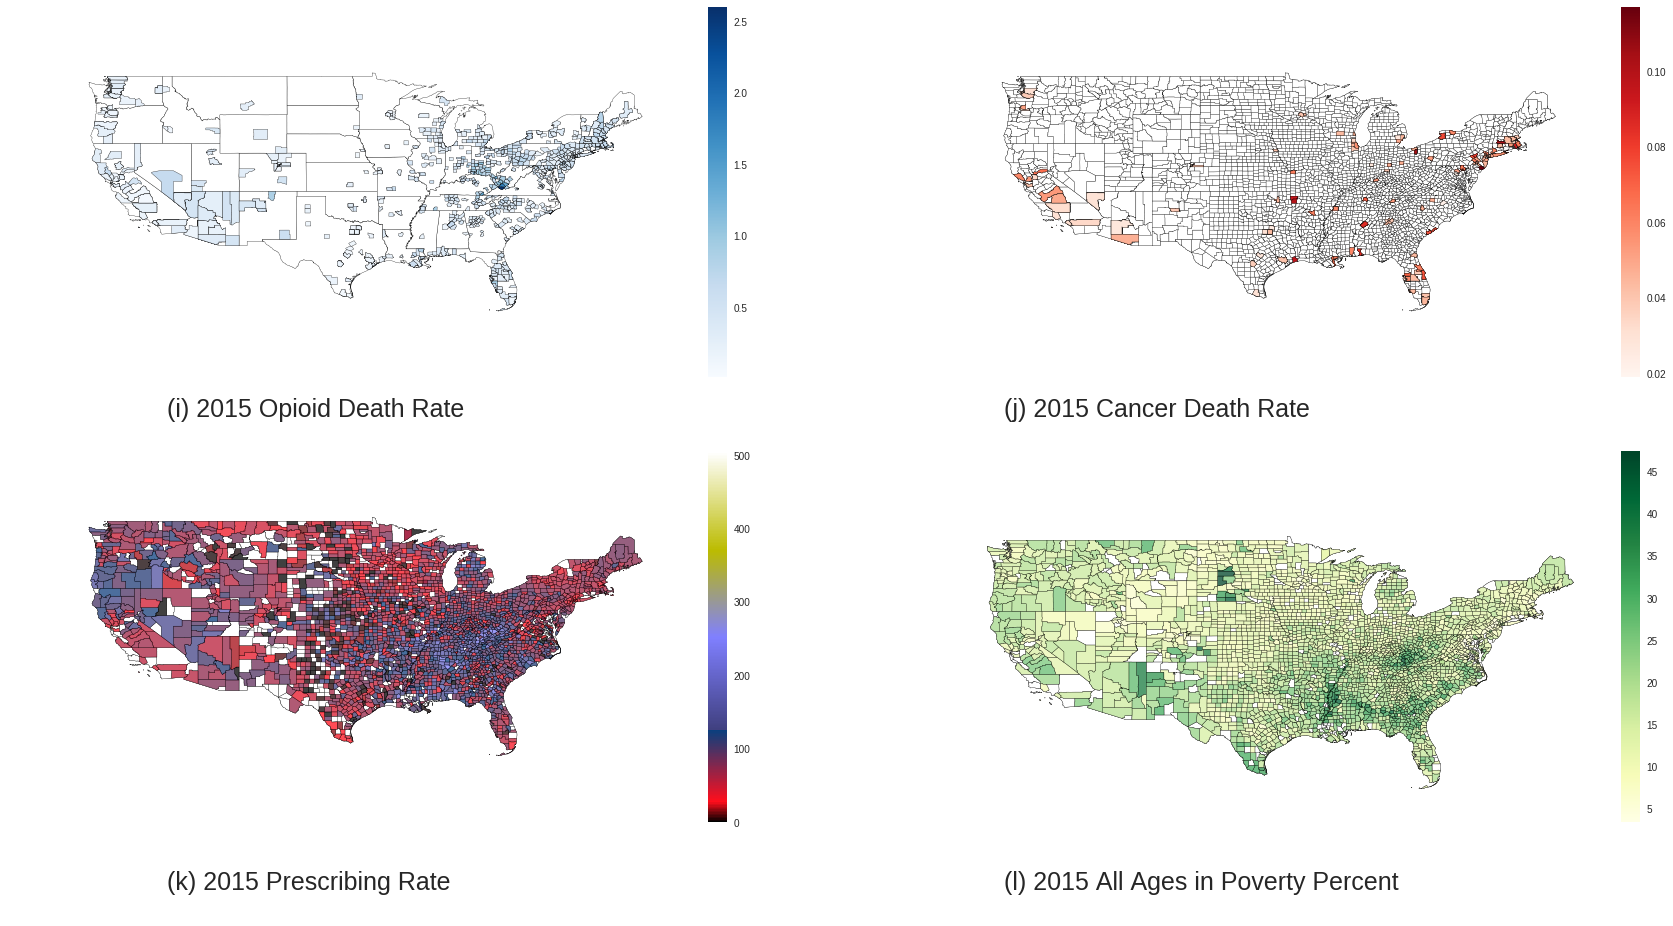

In [178]:
#Figure[1], Year 2015
#(a) Opioid Death Rate
fig, gax = plt.subplots(2,2 , figsize=(30,15))
plt.xlim([-126,-66])
plt.ylim([24,55])
states.plot(ax = gax[0,0], edgecolor='black',color= 'white' )
#counties.plot(ax=gax[0,0], edgecolor='black', color = 'white')
geo2015.dropna(subset=['OpioidDeathRate2015']).plot(ax=gax[0,0], edgecolor='black', 
                                                    column='OpioidDeathRate2015',  legend=True, cmap='Blues')
gax[0,0].annotate('(i) 2015 Opioid Death Rate',xy=(0.1, 0.55),  xycoords='figure fraction',size = 25)
#gax.set_title('Figure[2], U.S County Opioid Death Rate, 2014', size = 30)
gax[0,0].axis('off')


#(b) Cancer Death Rate
states.plot(ax = gax[0,1], edgecolor='black',color= 'white' )
counties.plot(ax=gax[0,1], edgecolor='black', color = 'white')
geo2015.dropna(subset=['CancerDeathRate2015']).plot(ax=gax[0,1], edgecolor='black', 
                                                    column='CancerDeathRate2015',  legend=True, cmap='Reds')
gax[0,1].annotate('(j) 2015 Cancer Death Rate',xy=(0.6, 0.55),  xycoords='figure fraction', size = 25)
gax[0,1].axis('off')


#(c) Prescribing Rate
states.plot(ax = gax[1,0], edgecolor='black',color= 'white' )
counties.plot(ax=gax[1,0], edgecolor='black', color = 'white')
geo2015.dropna(subset=['PrescribingRate2015']).plot(ax=gax[1,0], edgecolor='black', 
                                                    column='PrescribingRate2015',  legend=True, 
                                                    cmap='gist_stern',alpha = 0.75)
gax[1,0].annotate('(k) 2015 Prescribing Rate',xy=(0.1, 0.04),  xycoords='figure fraction', size = 25)
gax[1,0].axis('off')


#(d) All Ages in Poverty Percent
states.plot(ax = gax[1,1], edgecolor='black',color= 'white' )
counties.plot(ax=gax[1,1], edgecolor='black', color = 'white')
geo2015.dropna(subset=['ProvertyPre']).plot(ax=gax[1,1], edgecolor='black', 
                                            column='ProvertyPre',  legend=True, cmap='YlGn',alpha = 0.75)
gax[1,1].annotate('(l) 2015 All Ages in Poverty Percent',xy=(0.6, 0.04),  xycoords='figure fraction', size = 25)
gax[1,1].axis('off')
plt.show()

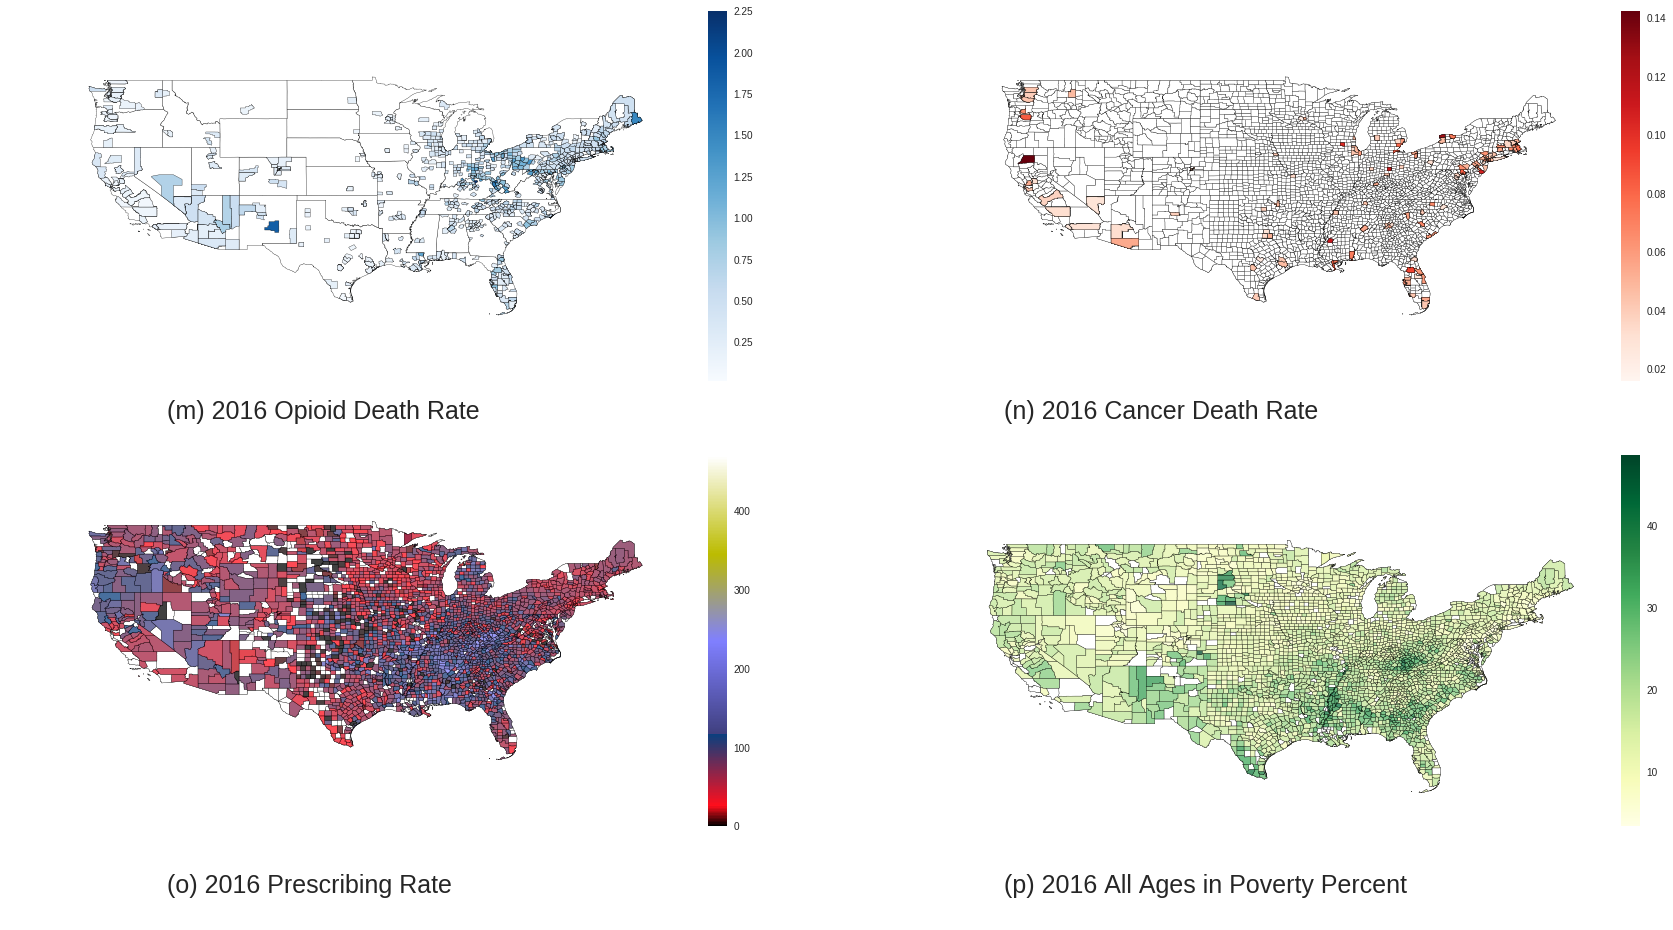

In [179]:
#Figure[1], Year 2016
#(a) Opioid Death Rate
fig, gax = plt.subplots(2,2 , figsize=(30,15))
plt.xlim([-126,-66])
plt.ylim([24,55])
states.plot(ax = gax[0,0], edgecolor='black',color= 'white' )
#counties.plot(ax=gax[0,0], edgecolor='black', color = 'white')
geo2016.dropna(subset=['OpioidDeathRate2016']).plot(ax=gax[0,0], edgecolor='black', 
                                                    column='OpioidDeathRate2016',  legend=True, cmap='Blues')
gax[0,0].annotate('(m) 2016 Opioid Death Rate',xy=(0.1, 0.55),  xycoords='figure fraction',size = 25)
#gax.set_title('Figure[2], U.S County Opioid Death Rate, 2014', size = 30)
gax[0,0].axis('off')


#(b) Cancer Death Rate
states.plot(ax = gax[0,1], edgecolor='black',color= 'white' )
counties.plot(ax=gax[0,1], edgecolor='black', color = 'white')
geo2016.dropna(subset=['CancerDeathRate2016']).plot(ax=gax[0,1], edgecolor='black', 
                                                    column='CancerDeathRate2016',  legend=True, cmap='Reds')
gax[0,1].annotate('(n) 2016 Cancer Death Rate',xy=(0.6, 0.55),  xycoords='figure fraction', size = 25)
gax[0,1].axis('off')


#(o) Prescribing Rate
states.plot(ax = gax[1,0], edgecolor='black',color= 'white' )
counties.plot(ax=gax[1,0], edgecolor='black', color = 'white')
geo2016.dropna(subset=['PrescribingRate2016']).plot(ax=gax[1,0], edgecolor='black', 
                                                    column='PrescribingRate2016',  legend=True, 
                                                    cmap='gist_stern',alpha = 0.75)
gax[1,0].annotate('(o) 2016 Prescribing Rate',xy=(0.1, 0.04),  xycoords='figure fraction', size = 25)
gax[1,0].axis('off')


#(d) All Ages in Poverty Percent
states.plot(ax = gax[1,1], edgecolor='black',color= 'white' )
counties.plot(ax=gax[1,1], edgecolor='black', color = 'white')
geo2016.dropna(subset=['ProvertyPre']).plot(ax=gax[1,1], edgecolor='black', 
                                            column='ProvertyPre',  legend=True, cmap='YlGn',alpha = 0.75)
gax[1,1].annotate('(p) 2016 All Ages in Poverty Percent',xy=(0.6, 0.04),  xycoords='figure fraction', size = 25)
gax[1,1].axis('off')
plt.show()

The plot above shows the Opioid Death rate, the cancer death rate, the prescribing rate and the poverty percent in 2013 to 2016. 

What we can find out from the plot is most Opioid death happened in the counties with the high cancer death rate, high prescribing rate, and high poverty percent. ( the deep colors all located at approximately the same area), we can find out the opioid death are mostly on the east coast and someplace on the west coast. This distribution is the same for all plots above in each year. 

### Horizontal Comparison

In order to find out the change during years change, we can make a plot conduct all the plot above, using year as x-axis and four factors as y-axis.

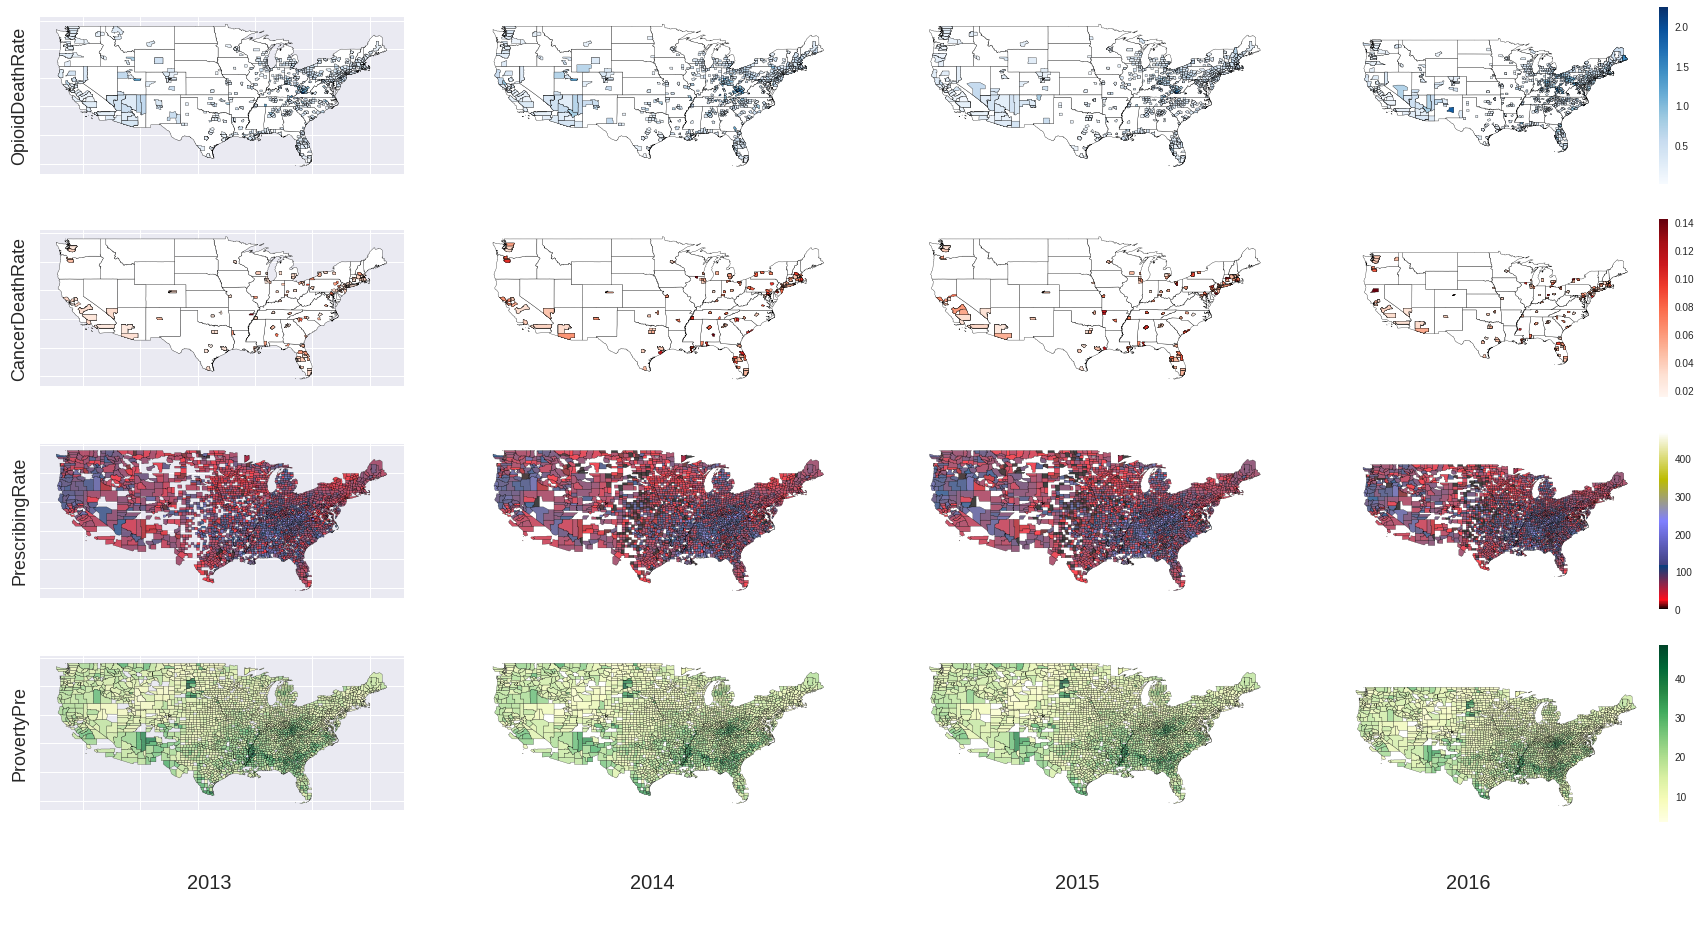

In [180]:
# the big picture

fig, gax = plt.subplots(4,4 , figsize=(30,15))
plt.xlim([-126,-66])
plt.ylim([24,55])
# (a) Opioid Death Rate 2013
states.plot(edgecolor='black',color= 'white' ,ax=gax[0,0])
geo2013.dropna(subset=['OpioidDeathRate2013']).plot(edgecolor='black', 
                                                    column='OpioidDeathRate2013',  legend=False, 
                                                    cmap='Blues',ax=gax[0,0])
gax[0,0].spines['left'].set_visible(False)
gax[0,0].spines['bottom'].set_visible(False)
gax[0,0].spines['right'].set_visible(False)
gax[0,0].spines['top'].set_visible(False)
gax[0,0].yaxis.set_label_text('OpioidDeathRate', size = 18)
gax[0,0].set_yticklabels([])
gax[0,0].set_xticklabels([])

#(e) Opioid Death Rate 2014
states.plot(ax = gax[0,1], edgecolor='black',color= 'white' )
#counties.plot(ax=gax[0,1], edgecolor='black', color = 'white')
geo2014.dropna(subset=['OpioidDeathRate2014']).plot(ax=gax[0,1], edgecolor='black', 
                                                    column='OpioidDeathRate2014',  legend=False, cmap='Blues')
gax[0,1].axis('off')

#(i) Opioid Death Rate 2015
states.plot(ax = gax[0,2], edgecolor='black',color= 'white' )
geo2015.dropna(subset=['OpioidDeathRate2015']).plot(ax=gax[0,2], edgecolor='black', 
                                                    column='OpioidDeathRate2015',  legend=False, cmap='Blues')
gax[0,2].axis('off')

#(m) Opioid Death Rate 2016
states.plot(ax = gax[0,3], edgecolor='black',color= 'white' )
geo2016.dropna(subset=['OpioidDeathRate2016']).plot(ax=gax[0,3], edgecolor='black', 
                                                    column='OpioidDeathRate2016',  legend=True, cmap='Blues')
gax[0,3].axis('off')




#(b) Cancer Death Rate 2013
states.plot(edgecolor='black',color= 'white', ax=gax[1,0])
geo2013.dropna(subset=['CancerDeathRate2013']).plot( edgecolor='black', 
                                                    column='CancerDeathRate2013',  legend=False,
                                                    cmap='Reds',ax=gax[1,0])
gax[1,0].spines['left'].set_visible(False)
gax[1,0].spines['bottom'].set_visible(False)
gax[1,0].spines['right'].set_visible(False)
gax[1,0].spines['top'].set_visible(False)
gax[1,0].yaxis.set_label_text('CancerDeathRate', size = 18)
gax[1,0].set_yticklabels([])
gax[1,0].set_xticklabels([])


#(f) Cancer Death Rate 2014
states.plot(ax = gax[1,1], edgecolor='black',color= 'white' )
geo2014.dropna(subset=['CancerDeathRate2014']).plot(ax=gax[1,1], edgecolor='black', 
                                                    column='CancerDeathRate2014',  legend=False, cmap='Reds')
gax[1,1].axis('off')


#(j) Cancer Death Rate 2015
states.plot(ax = gax[1,2], edgecolor='black',color= 'white' )
geo2015.dropna(subset=['CancerDeathRate2015']).plot(ax=gax[1,2], edgecolor='black', 
                                                    column='CancerDeathRate2015',  legend=False, cmap='Reds')
gax[1,2].axis('off')


#(n) Cancer Death Rate 2016
states.plot(ax = gax[1,3], edgecolor='black',color= 'white' )
geo2016.dropna(subset=['CancerDeathRate2016']).plot(ax=gax[1,3], edgecolor='black', 
                                                    column='CancerDeathRate2016',  legend=True, cmap='Reds')
gax[1,3].axis('off')


#(c) Prescribing Rate 2013
geo2013.dropna(subset=['PrescribingRate2013']).plot( edgecolor='black', 
                                                    column='PrescribingRate2013',  legend=False, 
                                                    cmap='gist_stern',alpha = 0.75,ax=gax[2,0])
gax[2,0].spines['left'].set_visible(False)
gax[2,0].spines['bottom'].set_visible(False)
gax[2,0].spines['right'].set_visible(False)
gax[2,0].spines['top'].set_visible(False)
gax[2,0].yaxis.set_label_text('PrescribingRate', size = 18)
gax[2,0].set_yticklabels([])
gax[2,0].set_xticklabels([])

#(g) Prescribing Rate 2014
geo2014.dropna(subset=['PrescribingRate2014']).plot(ax=gax[2,1], edgecolor='black', 
                                                    column='PrescribingRate2014',  legend=False, 
                                                    cmap='gist_stern',alpha = 0.75)
gax[2,1].axis('off')


#(k) Prescribing Rate 2015
geo2015.dropna(subset=['PrescribingRate2015']).plot(ax=gax[2,2], edgecolor='black', 
                                                    column='PrescribingRate2015',  legend=False, 
                                                    cmap='gist_stern',alpha = 0.75)
gax[2,2].axis('off')



#(o) Prescribing Rate 2016
geo2016.dropna(subset=['PrescribingRate2016']).plot(ax=gax[2,3], edgecolor='black', 
                                                    column='PrescribingRate2016',  legend=True, 
                                                    cmap='gist_stern',alpha = 0.75)
gax[2,3].axis('off')


#(d) All Ages in Poverty Percent 2013
geo2013.dropna(subset=['ProvertyPre']).plot( edgecolor='black', 
                                            column='ProvertyPre',  legend=False, 
                                            cmap='YlGn',alpha = 0.75,ax=gax[3,0])
gax[3,0].annotate('2013',xy=(0.11, 0.04),  xycoords='figure fraction', size = 20)
gax[3,0].spines['left'].set_visible(False)
gax[3,0].spines['bottom'].set_visible(False)
gax[3,0].spines['right'].set_visible(False)
gax[3,0].spines['top'].set_visible(False)
gax[3,0].yaxis.set_label_text('ProvertyPre', size = 18)
gax[3,0].set_yticklabels([])
gax[3,0].set_xticklabels([])

#(h) All Ages in Poverty Percent 2014
geo2014.dropna(subset=['ProvertyPre']).plot(ax=gax[3,1], edgecolor='black', 
                                            column='ProvertyPre',  legend=False, cmap='YlGn',alpha = 0.75)
gax[3,1].annotate('2014',xy=(0.37, 0.04),  xycoords='figure fraction', size = 20)
gax[3,1].axis('off')


#(l) All Ages in Poverty Percent 2015
geo2015.dropna(subset=['ProvertyPre']).plot(ax=gax[3,2], edgecolor='black', 
                                            column='ProvertyPre',  legend=False, cmap='YlGn',alpha = 0.75)
gax[3,2].annotate('2015',xy=(0.62, 0.04),  xycoords='figure fraction', size = 20)
gax[3,2].axis('off')

#(d) All Ages in Poverty Percent 2016
geo2016.dropna(subset=['ProvertyPre']).plot(ax=gax[3,3], edgecolor='black', 
                                            column='ProvertyPre',  legend=True, cmap='YlGn',alpha = 0.75)
gax[3,3].annotate('2016',xy=(0.85, 0.04),  xycoords='figure fraction', size = 20)
gax[3,3].axis('off')
plt.show()


**This is amazing!**
From above, we can analyze the factor for yearly change just by the plot of map. 

From the color change from light to deep, we can notice the rates are keeping increasing from 2013 to 2016. Most death are happend in the east coast with large veriation with mostly spread out. But we can see from the plot, the most density area located in northeast, which are states like New York, Massachusetts, and New Jersey. 

Also, from the graph, it's not to find out that the place with higher proverty rate share the higher prescribing rate, which is also related with both death rate. 

From the plot, it is hard to find out the detials for the change or the relationship between, So I'm using ANOVA and regression to dig out the relationship between them.

### ANOVA for category data (race)

In [181]:
data_l_lm = smf.ols('Deaths ~ C(Race)', data=data_l).fit()
table = sm.stats.anova_lm(data_l_lm, typ=2) # Type 2 ANOVA DataFrame
print(table)
print(data_l_lm.summary())



                sum_sq      df          F        PR(>F)
C(Race)   9.597206e+04     3.0  15.264987  6.933151e-10
Residual  1.040720e+07  4966.0        NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                 Deaths   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     15.26
Date:                Tue, 11 Dec 2018   Prob (F-statistic):           6.93e-10
Time:                        14:14:04   Log-Likelihood:                -26055.
No. Observations:                4970   AIC:                         5.212e+04
Df Residuals:                    4966   BIC:                         5.214e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          

This is the table that shows the output of the ANOVA analysis and whether there is a statistically significant difference between rece groups. We can see that the significance value is 6.933151e-10 (i.e., p = 6.933151e-10), which is below 0.05. and, therefore, there is a statistically significant difference in the Opioid death rate between the different race groups. This is great to know, but we do not know which of the specific groups differed. Luckily, we can find this out in the Multiple Comparisons table which contains the results of the race group regression.

From the OLS regression table, we can find out that the coeficient for Asian or Pacific Islander, Black or African American, and White, whcih shows Asian have the lowest coefficient, and the white have the highest. As the result, we can speculate most people suffer from Opioid crisis are white people, and Black communite are follow behind, then will be other groups like Asian and Pacific islander. 

### Plot the regression distribution

Form the previous mapping, we find out the Opioid death rates are possiblly related with factors such as Prescribing rate in each county, the Proverty rate, and the cancer death rate.

In order to find out the regression, I first dealing with the missing value in my data, I use `interpolate()` as my fitter to generate the missing data in my datasets. 

Then, Plot the scatter plot to show the relations.

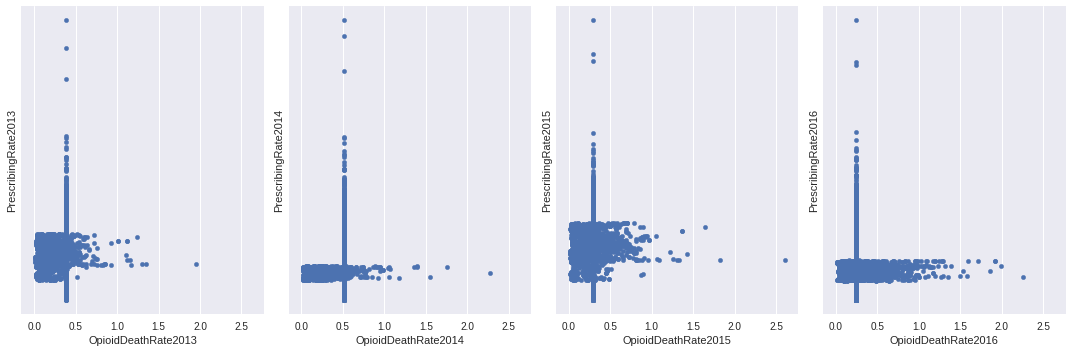

In [183]:
## import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True)

plt.style.use('seaborn')

data_2013 = data_2013.interpolate()
data_2014 = data_2014.interpolate()
data_2015 = data_2015.interpolate()
data_2016 = data_2016.interpolate()



data_2013.plot(x='OpioidDeathRate2013', y='PrescribingRate2013', kind='scatter', ax=axes[0])
data_2014.plot(x='OpioidDeathRate2014', y='PrescribingRate2014', kind='scatter', ax=axes[1])
data_2015.plot(x='OpioidDeathRate2015', y='PrescribingRate2015', kind='scatter', ax=axes[2])
data_2016.plot(x='OpioidDeathRate2016', y='PrescribingRate2016', kind='scatter', ax=axes[3])

 
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

The plot above shows the relationship between opioid death rate and prescribing rate in each year from 2013 to 2016, we can find out that the prescribing rate is suddently increasing in 2015 (spread out in y), and as the result, the opioid death rate is increasing in teh 2016 (spread out in x). 

We can ignore the density number like the bar in the graph, that's NaN generate provide the fitting value for NaN. 


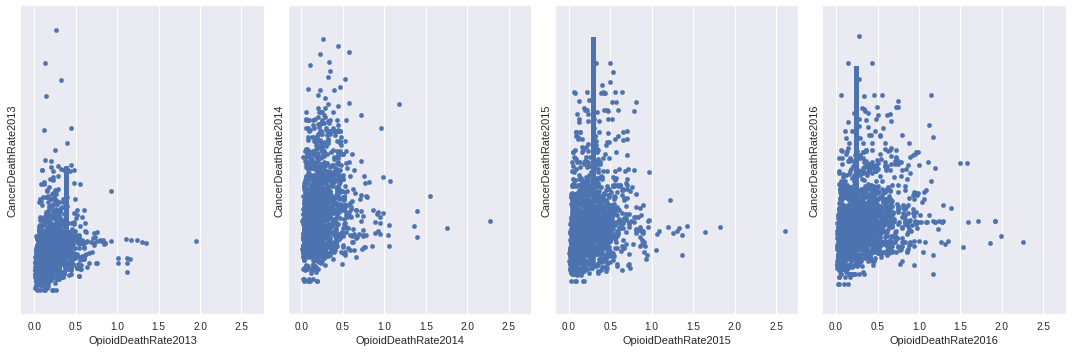

In [187]:
## import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True)

plt.style.use('seaborn')

data_2013.plot(x='OpioidDeathRate2013', y='CancerDeathRate2013', kind='scatter', ax=axes[0])
data_2014.plot(x='OpioidDeathRate2014', y='CancerDeathRate2014', kind='scatter', ax=axes[1])
data_2015.plot(x='OpioidDeathRate2015', y='CancerDeathRate2015', kind='scatter', ax=axes[2])
data_2016.plot(x='OpioidDeathRate2016', y='CancerDeathRate2016', kind='scatter', ax=axes[3])

plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Same as before, ignore the bar shape data as NaN

We can see the Opoiod death rate related to cancer death rate and opioid death rate relationship from above. 2013 to 2016, the data spread out a lot compared with the beginning year in 2013 (the shape change from a _bar shape_ in 2013 to _round shape_ in 2016, which we can see the relationship between this two variable is more and more related. The more spread out data shows the approximately the **linear regression** between the two variables.  

### linear regression 

To prove what we have from the plot above, we do the OLS linear regression to see if the result is right.

First we do the ols between Opioid Death Rate and Prescribing Rate for each year.

In [188]:
#OpioidDeathRate2013"vs'PrescribingRate2013
data_2013 = data_2013.dropna(subset = ["OpioidDeathRate2013",'PrescribingRate2013'])
res_2013 = smf.ols('OpioidDeathRate2013 ~ PrescribingRate2013', data=data_2013,missing='drop').fit()
print(res_2013.summary())


                             OLS Regression Results                            
Dep. Variable:     OpioidDeathRate2013   R-squared:                       0.006
Model:                             OLS   Adj. R-squared:                  0.005
Method:                  Least Squares   F-statistic:                     42.02
Date:                 Tue, 11 Dec 2018   Prob (F-statistic):           9.61e-11
Time:                         14:32:11   Log-Likelihood:                 7193.9
No. Observations:                 7432   AIC:                        -1.438e+04
Df Residuals:                     7430   BIC:                        -1.437e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

From above, we can see the relationship between Opioid death rate and Prescribing Rate in 2013; the coef is **-0.002** which is the negative relationship with a negative slope. The increasing of the prescribing rate would cause decreasing of the opioid death rate. 

this means, 2013 looks not too bad for us, at least the prescription could save people from suffering. 

In [208]:
data_2014 = data_2014.dropna(subset = ["OpioidDeathRate2014",'PrescribingRate2014'])
res_2014 = smf.ols('OpioidDeathRate2014 ~ PrescribingRate2014', data=data_2014,missing='drop').fit()
print(res_2014.summary())


                             OLS Regression Results                            
Dep. Variable:     OpioidDeathRate2014   R-squared:                       0.040
Model:                             OLS   Adj. R-squared:                  0.039
Method:                  Least Squares   F-statistic:                     310.1
Date:                 Tue, 11 Dec 2018   Prob (F-statistic):           4.72e-68
Time:                         15:13:59   Log-Likelihood:                 4914.8
No. Observations:                 7524   AIC:                            -9826.
Df Residuals:                     7522   BIC:                            -9812.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

From above, we can see the relationship between Opioid death rate and Prescribing Rate in 2014; the coef is **0.0012** which is the positive relationship with a positive slope. The increasing of the prescribing rate would cause increasing of the opioid death rate. 


In [193]:
data_2015 = data_2015.dropna(subset = ["OpioidDeathRate2015",'PrescribingRate2015'])
res_2015 = smf.ols('OpioidDeathRate2015 ~ PrescribingRate2015', data=data_2015,missing='drop').fit()
print(res_2015.summary())

                             OLS Regression Results                            
Dep. Variable:     OpioidDeathRate2015   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     1.257
Date:                 Tue, 11 Dec 2018   Prob (F-statistic):              0.262
Time:                         14:57:50   Log-Likelihood:                 7108.8
No. Observations:                 7571   AIC:                        -1.421e+04
Df Residuals:                     7569   BIC:                        -1.420e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

From above, we can see the relationship between Opioid death rate and Prescribing Rate in 2015, the coef is **1.105e-05** which is the positive relationship with positive slope. the increasing of the prescribing rate would cause increasing of the opioid death rate.

As one of the most horrible year for opioid crisis, this result is not suprise. From 2014 to 2015, the prescribtion of Opioid medicine affect the opioid crisis a lot.

In [194]:
data_2016 = data_2016.dropna(subset = ["OpioidDeathRate2016",'PrescribingRate2016'])
res_2016 = smf.ols('OpioidDeathRate2016 ~ PrescribingRate2016', data=data_2016,missing='drop').fit()
print(res_2016.summary())

                             OLS Regression Results                            
Dep. Variable:     OpioidDeathRate2016   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     17.80
Date:                 Tue, 11 Dec 2018   Prob (F-statistic):           2.49e-05
Time:                         14:57:51   Log-Likelihood:                 4766.9
No. Observations:                 7835   AIC:                            -9530.
Df Residuals:                     7833   BIC:                            -9516.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

From above, we can see the relationship between Opioid death rate and Prescribing Rate in 2016, and the coef is **-0.0007** which is the negative relationship with a negative slope. The increasing of the prescribing rate would cause decreasing of the opioid death rate.

We can see from the result, the coef change to negative, which might be relative with the limitation of prescribing limitation assign by the government in 2016, it works, which bring the problem back to normal.


### regression plot
In order to show the relationship strightly, we make the graph below the show the relationship.

Text(0.5, 1.0, 'Predicted Prescribing Rate probabilities from an OLS model')

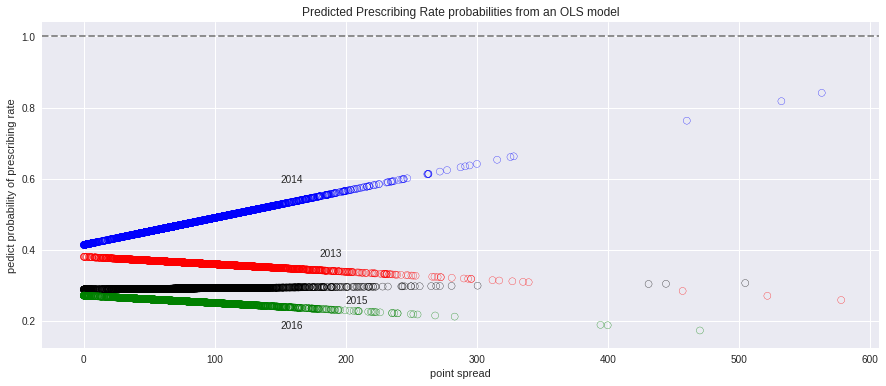

In [200]:
fig, ax = plt.subplots(figsize=(15,6))

ax.scatter(data_2013['PrescribingRate2013'], res_2013.fittedvalues,  facecolors='none', edgecolors='red')
ax.scatter(data_2014['PrescribingRate2014'], res_2014.fittedvalues,  facecolors='none', edgecolors='blue')
ax.scatter(data_2015['PrescribingRate2015'], res_2015.fittedvalues,  facecolors='none', edgecolors='black')
ax.scatter(data_2016['PrescribingRate2016'], res_2016.fittedvalues,  facecolors='none', edgecolors='green')

ax.text(180, 0.38, '2013')        
ax.text(150, 0.59, '2014')
ax.text(200, 0.25, '2015')
ax.text(150, 0.18, '2016')

ax.axhline(y=1.0, color='grey', linestyle='--')

ax.set_ylabel('pedict probability of prescribing rate')
ax.set_xlabel('point spread')
ax.set_title('Predicted Prescribing Rate probabilities from an OLS model')

As the result showing above, the relationship is fit for what we get from the table, the coef is decreaing in 2013 and 2016 and increasing in 2014 to 2015. We can find out that the 2014 is increasing a lot which is the year mostly affected by the prescribing.

same as above plot, we can also get the result for cancer death rates

Text(0.5, 1.0, 'Predicted Cancer Death Rate probabilities from an OLS model')

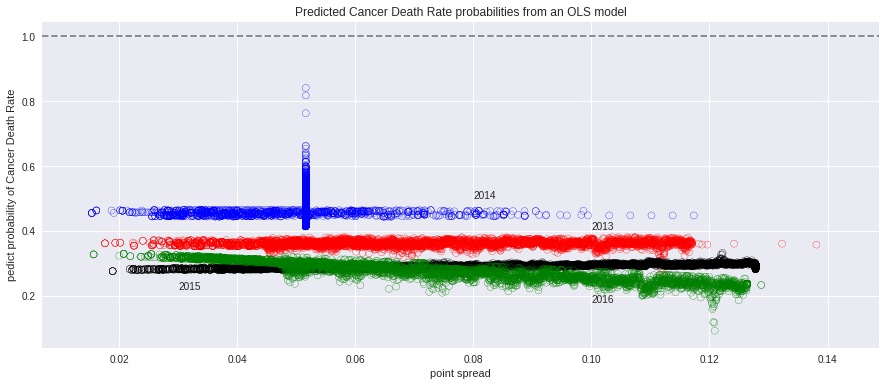

In [213]:
fig, ax = plt.subplots(figsize=(15,6))

ax.scatter(data_2013['CancerDeathRate2013'], res_2013.fittedvalues,  facecolors='none', edgecolors='red')
ax.scatter(data_2014['CancerDeathRate2014'], res_2014.fittedvalues,  facecolors='none', edgecolors='blue')
ax.scatter(data_2015['CancerDeathRate2015'], res_2015.fittedvalues,  facecolors='none', edgecolors='black')
ax.scatter(data_2016['CancerDeathRate2016'], res_2016.fittedvalues,  facecolors='none', edgecolors='green')

ax.axhline(y=1.0, color='grey', linestyle='--')

ax.text(0.1, 0.405, '2013')        
ax.text(0.08, 0.5, '2014')
ax.text(0.03, 0.22, '2015')
ax.text(0.1, 0.18, '2016')

ax.set_ylabel('pedict probability of Cancer Death Rate')
ax.set_xlabel('point spread')
ax.set_title('Predicted Cancer Death Rate probabilities from an OLS model')

From above show the reationship between opioid death rate and cancer death rate. which we can find out the 2014 share the high cancer death rate than other years. 

The plot above show the opioid death rate related with all ages in prverty. 


In order to show all other factors which might effect the opioid death rate, we do the linear regression for all factors.

The table below shows the linear regression between each factor, we can find out that all the coef are positive, which we can infer that the 2014 was a big year for opioid using, and cancer death rate was the most effective element for opioid, which have coef as **4.4823** which is higner than other factors.

In [222]:
data_2013.fillna(0, inplace = True)
res_2013_all = smf.ols('OpioidDeathRate2013 ~ PrescribingRate2013 + CancerDeathRate2013 + ProvertyPre', data=data_2013).fit()
print(res_2013_all.summary())

                             OLS Regression Results                            
Dep. Variable:     OpioidDeathRate2013   R-squared:                       0.179
Model:                             OLS   Adj. R-squared:                  0.178
Method:                  Least Squares   F-statistic:                     538.3
Date:                 Tue, 11 Dec 2018   Prob (F-statistic):          1.38e-316
Time:                         16:11:03   Log-Likelihood:                 7904.0
No. Observations:                 7432   AIC:                        -1.580e+04
Df Residuals:                     7428   BIC:                        -1.577e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

In [219]:
data_2014.fillna(0, inplace = True)
res_2014_all = smf.ols('OpioidDeathRate2014 ~ PrescribingRate2014 + CancerDeathRate2014 + ProvertyPre', data=data_2014).fit()
print(res_2014_all.summary())

                             OLS Regression Results                            
Dep. Variable:     OpioidDeathRate2013   R-squared:                       0.179
Model:                             OLS   Adj. R-squared:                  0.178
Method:                  Least Squares   F-statistic:                     538.3
Date:                 Tue, 11 Dec 2018   Prob (F-statistic):          1.38e-316
Time:                         15:58:30   Log-Likelihood:                 7904.0
No. Observations:                 7432   AIC:                        -1.580e+04
Df Residuals:                     7428   BIC:                        -1.577e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

In [220]:
data_2015.fillna(0, inplace = True)
res_2015_all = smf.ols('OpioidDeathRate2015 ~ PrescribingRate2015 + CancerDeathRate2015 + ProvertyPre', data=data_2015).fit()
print(res_2015_all.summary())

                             OLS Regression Results                            
Dep. Variable:     OpioidDeathRate2015   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     7.037
Date:                 Tue, 11 Dec 2018   Prob (F-statistic):           0.000101
Time:                         15:59:07   Log-Likelihood:                 7118.7
No. Observations:                 7571   AIC:                        -1.423e+04
Df Residuals:                     7567   BIC:                        -1.420e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

In [221]:
data_2016.fillna(0, inplace = True)
res_2016_all = smf.ols('OpioidDeathRate2016 ~ PrescribingRate2016 + CancerDeathRate2016 + ProvertyPre', data=data_2016).fit()
print(res_2016_all.summary())

                             OLS Regression Results                            
Dep. Variable:     OpioidDeathRate2016   R-squared:                       0.050
Model:                             OLS   Adj. R-squared:                  0.050
Method:                  Least Squares   F-statistic:                     137.3
Date:                 Tue, 11 Dec 2018   Prob (F-statistic):           1.06e-86
Time:                         15:59:31   Log-Likelihood:                 4958.9
No. Observations:                 7835   AIC:                            -9910.
Df Residuals:                     7831   BIC:                            -9882.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

# Summary

### Conclusion 

**As a result, we can see the opioid cause death rate with cancer death rate is mostly correlated, and 2014 have the most massive increasing rate in the opioid cause of death.**

Prescription opioids can be used to treat moderate-to-severe pain and are often prescribed following surgery or injury, or for health conditions such as cancer. In recent years, there has been a dramatic increase in the acceptance and use of prescription opioids for the treatment of chronic, non-cancer pain, such as back pain or osteoarthritis, despite serious risks and the lack of evidence about their long-term effectiveness. As one of the most effective elements for the opioid cause of death, the government should control the prescription opioids with strict law to decreasing the opioid using from the beginning.

But sometimes the prescription opioid could be helpful, especially on the cancer treatment, that's the reason why the cancer death rate is mostly related to opioid cause death rate. As the way to figure this, I suggest people using some alternative medicines which might not as good as opioid medicines, but without addiction. 

Surprisingly, I find the relation between poverty rate and opioid was changed during the years, the higher poverty rate cause the high opioid death rate in 2013, but from 2014, the higher poverty rate cause the decreasing of the opioid death rate. I did some search on the website, which the result show the pricing of opioid medicines was increasing serval times during 2013 to 2015, and that might the reason cause the poor people cannot afford the medication for cancer or opioid using which produce the high increase in both death rate. To solve this, I think the government needs to provide some law to limit opioid medicine pricing change. I know some medicine company produces opioid because the huge benefit behind it, with the regulation or restriction, the balance between profit and manufacturing would be a break so that the opioid could be replaced by something else which more useful for treatment. 

### Future Directions

The weaknesses of my model can be overcome. The important weakness of low sample size after merge can be remedied by waiting until more data becomes available as time passes. 

The method in real life problem always have a lot of missing value, this mtheod was not doing good work on that which replace the missing value by some basic method such as mean and median. In a good way to solve this, I can apply linear regression between my variables, or using K-NN methed to generate the most fittble numbers for the missing value, which will lower the varience of the data. 

Our analysis also fails to include the fact that the month or day likely has a strong effect on opioid cause of death, so implementing some sort of time series analysis would likely give me greater power in detecting differences in our variables of interest. 

Other ways to improve the model include the use of cross-validation to see if a polynomial term of some variables could provide more predictive power without overfitting. 


Other areas of interest for analysis would be to make comparisons between some big cities such as NYC or Miami city instead of just doing an analysis of the counties.



# Reference

[1] Center of Disease Control and Prevention. (2018, December 5).Multiple Cause of Death, 1999-2017 Request. Retrieved December 5, 2018, from https://wonder.cdc.gov/mcd.html


[2] Center of Disease Control and Prevention. (2018, December 5).Prescription Opioid Data. Retrieved December 5, 2018, from https://www.cdc.gov/drugoverdose/data/prescribing.html


[3] Center of Disease Control and Prevention. (2018, December 5).Cancer Data and Statistics. Retrieved December 5, 2018, from https://www.cdc.gov/cancer/dcpc/data/index.html


[4] U.S. Census Bureau. (2018, December 5).Income and Poverty in the United States (2013-2016) Retrieved December 5, 2018, from https://www.census.gov/data/tables/2017/demo/income-poverty/p60-259.html


[5] U.S. Census Bureau. (2018, December 5).Cartographic Boundary Shapefiles - States. Retrieved December 5, 2018, from https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html


[6] U.S. Census Bureau. (2018, December 5).Cartographic Boundary Shapefiles - Counties. Retrieved December 5, 2018, from https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html